# GPU Computing for Data Scientists
#### Using CUDA, Jupyter, PyCUDA, ArrayFire and Thrust


https://github.com/QuantScientist/Data-Science-ArrayFire-GPU

In [1]:
# !pip install pycuda
%reset -f
import pycuda
from pycuda import compiler
import pycuda.driver as cuda
import numpy
import numpy as np

from pycuda.compiler import SourceModule

cuda.init()
print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print "Device #%d: %s" % (ordinal, dev.name())    

print cuda

1 device(s) found.
Device #0: GeForce GTX 1080
<module 'pycuda.driver' from '/usr/local/lib/python2.7/dist-packages/pycuda/driver.pyc'>


-  Maximum thread size for GPU is dependent on GPU, but normally 512.
-  Threads per block should be a multiple of 32.
-  Block and Grid Size is dependent on the image.
-  This example uses a 256x256 pixel image. A 2D block (16x16) and a 1D grid (256,1) is used

## Sigmoid on the GPU

In [2]:
import pycuda.autoinit

# a = np.random.uniform(low=1, high=20, size=(10,))

# a = numpy.random.randn(1,9)
a = np.arange(-100000, 100000, 1)
a = a.astype(numpy.float32)
# print a


ARR_SIZE = numpy.int32(a.shape[-1])
print ARR_SIZE 

a_gpu = cuda.mem_alloc(a.nbytes)
xout_gpu = cuda.mem_alloc(a.nbytes)

cuda.memcpy_htod(a_gpu, a)
xout_gpu=cuda.mem_alloc_like(a)
# size_gpu=cuda.mem_alloc_like(size)

mod = SourceModule("""  
  
  __global__ void sigmoid(float* a, float* b, int size)
    {
        int index = blockDim.x * blockIdx.x + threadIdx.x;
        if (index < size)
            b[index] = 1.0f / (1.0f + exp(-1.0f * a[index]));
    }
  """)

# s_gpu=size.astype(numpy.int32)

func = mod.get_function("sigmoid")


def sigmoidGPU():
    func(a_gpu, xout_gpu,ARR_SIZE, block=(20,1,1))
    a_sigmoid = numpy.empty_like(a)
    cuda.memcpy_dtoh(a_sigmoid, xout_gpu)
    return a_sigmoid

# print sigmoidGPU()

from scipy.special import expit
y = expit(a)
# print ("__________________________________")
# print y

200000


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


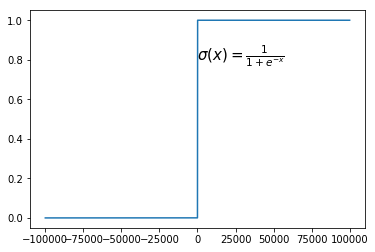

In [3]:
import matplotlib.pyplot as plt

plt.plot(a,y)
plt.text(4,0.8,r'$\sigma(x)=\frac{1}{1+e^{-x}}$',fontsize=15)
plt.legend(loc='lower right')
plt.show()

In [4]:
import timeit
n_iter = ARR_SIZE
rounds = 1000  # for timeit

print 'numpy', timeit.timeit(lambda: 
                              expit(a), 
                              number=rounds)

numpy 1.67365002632


In [5]:
print 'pycuda', timeit.timeit(lambda: 
                              sigmoidGPU(), 
                              number=rounds)


pycuda 0.140300989151
